**Letícia Oliveira Silva\
Otávio Santos Gomes**

# Projeto Final

Objetivo do projeto é explorar o debate ocorrido na rede Mastodon acerca dos dois grandes shows ocorridos no Brasil, mais especificamente no Rio de Janeiro, sendo eles o show da Madonna, ocorrido em 4 de maio de 2024, e o Show da Lady Gaga, ocorrido no dia 3 de maio de 2025.

O Mastodon é uma plataforma de microblog descentralizada, baseada em software livre, que se diferencia por seu modelo federado: os usuários estão distribuídos em diversas instâncias (servidores), mas podem interagir entre si independentemente da instância de origem. Essa arquitetura promove maior controle por parte dos usuários e comunidades, além de permitir acesso facilitado aos dados por meio de sua API pública, que segue o padrão REST e utiliza autenticação via OAuth 2.0. A documentação oficial pode ser encontrada em: https://docs.joinmastodon.org/api/.

Serão construídos dois grafos distintos, um para cada evento. Cada grafo será composto por postagens públicas coletadas a partir da instância mastodon.social, utilizando a API da plataforma. A coleta será orientada por palavras-chave e hashtags relacionadas a cada evento, como #Madonna, #Madonna2024, #Gaga e #LadyGaga.

Em ambos os grafos, os nós representarão os usuários que publicaram conteúdos utilizando as hashtags relacionadas ao respectivo evento. As arestas serão formadas com base nas interações entre esses usuários, incluindo menções, respostas e compartilhamentos (boosts).

Perguntas de pesquisa:

1. Quais as principais semelhanças e diferenças entre ambas as redes complexas do ponto de vista de suas características estruturais?

2. A estrutura da rede sugere maior centralização (influência de poucos nós) ou dispersão (discussão mais distribuída) em cada um dos eventos?

3. É possível identificar comunidades bem definidas dentro de cada rede?

4. É possível observar relações de homofilia?

5. Há usuários recorrentes nos dois eventos?


In [1]:
!pip install Mastodon.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 3.8 MB/s eta 0:00:00


In [2]:
from mastodon import Mastodon
from datetime import datetime, timezone
import csv
import html
import time
import networkx as nx

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

## Construção das Redes

Primeiramente, é preciso instânciar a API do Mastodon especificando a instância, que no caso será a intância principal `mastodon.social`

In [3]:
mastodon = Mastodon(api_base_url='https://mastodon.social')

### Show da Madonna

#### Coleta dos Dados

O show da Madonna ocorreu no dia 04/05/2024. Para a coleta, vamos considerar um mês antes e um mês depois do show.

In [4]:
#data do show = 04/05/2024
DATA_INICIO = datetime(2024, 4, 4, tzinfo=timezone.utc)
DATA_FIM = datetime(2024, 6, 4, tzinfo=timezone.utc)

A seleção dos posts foi feita utilizando filtros por hashtags e por termos presentes no conteúdo textual das publicações.

As hashtags e termos utilizados na coleta foram definidos de maneira exploratória com o objetivo de captar publicações com alto grau de associação explícita aos shows.

##### Toots [posts]

In [5]:
hashtags_coleta = ["madonna", "mastodonna", "thecelebrationtour","copacabana"] # hashtags a serem buscadas
palavras_chave = ["madonna"] # termos que devem aparecer no texto do toot

In [6]:
toots_coletados = []
ids_coletados = set()

for hashtag in hashtags_coleta:
    print(f"Buscando por #{hashtag}...", end='')
    count = 0
    max_id = None
    while True:
        toots = mastodon.timeline_hashtag(hashtag, max_id=max_id, limit=50)
        if not toots:
            break

        for toot in toots:
            data = toot['created_at']
            texto = html.unescape(toot['content']).lower()
            if data < DATA_INICIO:
                break
            if DATA_INICIO <= data <= DATA_FIM:
                if all(palavra in texto for palavra in palavras_chave):
                    if toot['id'] not in ids_coletados:
                        toots_coletados.append(toot)
                        ids_coletados.add(toot['id'])
                        count += 1

        max_id = toots[-1]['id']
        time.sleep(1)
    print(f'{count} toots')

print(f"\nTotal de toots coletados: {len(toots_coletados)}")

Buscando por #madonna...354 toots
Buscando por #mastodonna...19 toots
Buscando por #thecelebrationtour...0 toots
Buscando por #copacabana...0 toots

Total de toots coletados: 373


In [7]:
with open("toots_madonna.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=toots_coletados[0].keys(), quoting=csv.QUOTE_ALL)
    writer.writeheader()
    writer.writerows(toots_coletados)

print("Arquivo CSV salvo como 'toots_madonna.csv'")

Arquivo CSV salvo como 'toots_madonna.csv'


###### Mapear Usuários que Publicaram Toots

In [8]:
from collections import defaultdict
usuarios = defaultdict(list)

In [9]:
from bs4 import BeautifulSoup
import html
import re

for toot in toots_coletados:
    autor = toot['account']['acct']
    toot_id = toot['id']

    # Conteúdo
    conteudo_html = html.unescape(toot['content'])
    soup = BeautifulSoup(conteudo_html, 'html.parser')
    texto_limpo = soup.get_text(separator=' ').strip()

    # Idioma
    language = toot.get('language')

    usuarios[autor].append({'conteudo': texto_limpo,
                            'idioma': language,
                            'tipo': 'toot',
                            'original_autor': autor,
                            'toot_id':toot_id})

In [10]:
len(usuarios)

107

In [11]:
sum(len(lista) for lista in usuarios.values())

373

##### Interações

Com nossos vértices, agora precisamos coletar as arestas do nosso grafo. Os tipos de interação são:

* boost: usuário A deu boost num toot de B.

[No Mastodon, um boost é equivalente ao retweet do Twitter (ou X). Ele serve para recompartilhar uma publicação (toot) de outra pessoa com todos os seus seguidores, sem fazer alterações no conteúdo original]

* reply: A respondeu um toot de B.

* mention: A mencionou B num toot.

###### Boost

In [12]:
print("Coletando boost...")
interacoes_boost = []
for toot in toots_coletados:
    autor = toot['account']['acct']
    toot_id = toot['id']
    data = toot['created_at'].isoformat()

    conteudo_html = html.unescape(toot['content'])
    soup = BeautifulSoup(conteudo_html, 'html.parser')
    texto_limpo = soup.get_text(separator=' ').strip()

    language = toot['language']

    try:
        boost_users = mastodon.status_reblogged_by(toot_id)
        for u in boost_users:
            user = u['acct']
            interacoes_boost.append({'de': u['acct'], 'para': autor, 'tipo': 'boost', 'data': data})

            #adicionar ao usuário que deu boost no toot, as informações sobre o toot
            usuarios[user].append({'conteudo': texto_limpo,
                                    'idioma': language,
                                    'tipo': 'boost',
                                    'original_autor': autor,
                                    'toot_id':toot_id})
        time.sleep(1)
    except Exception as e:
        print(f"Erro boost toot {toot_id}: {e}")
print(len(interacoes_boost), 'boosts coletados')

Coletando boost...
54 boosts coletados


###### Mention

In [13]:
import re

print("Coletando mention...")
interacoes_mention = []
for toot in toots_coletados:
    autor = toot['account']['acct']
    toot_id = toot['id']
    data = toot['created_at'].isoformat()

    conteudo_html = html.unescape(toot['content'])
    soup = BeautifulSoup(conteudo_html, 'html.parser')
    texto_limpo = soup.get_text(separator=' ').strip()

    language = toot['language']

    mentions = re.findall(r'@([\w@.\-]+)', conteudo_html)
    for m in mentions:
        if m != autor:
            interacoes_mention.append({'de': autor, 'para': m, 'tipo': 'mention', 'data': data})

            usuarios[m].append({'conteudo': texto_limpo,
                                            'idioma': language,
                                            'tipo': 'mention',
                                            'original_autor': autor,
                                            'toot_id':toot_id})

print(len(interacoes_mention), 'menções coletadas')

Coletando mention...
17 menções coletadas


###### Reply

In [14]:
interacoes_reply = []

print("Coletando reply...")
for toot in toots_coletados:
    autor = toot['account']['acct']
    toot_id = toot['id']
    data = toot['created_at'].isoformat()

    # toot['in_reply_to_id']: ID do toot ao qual este toot é uma resposta.
    # toot['in_reply_to_account_id']: ID da conta à qual o toot respondido pertence (o autor do toot original).

    if toot['in_reply_to_account_id']:
        try:
            alvo = mastodon.account(toot['in_reply_to_account_id'])['acct']
            interacoes_reply.append({'de': autor, 'para': alvo, 'tipo': 'reply', 'data': data})

            #coleta o toot original respondido
            toot_respondido = mastodon.status(toot['in_reply_to_id'])
            conteudo_respondido = BeautifulSoup(html.unescape(toot_respondido['content']), 'html.parser').get_text(separator=' ').strip()
            language = toot_respondido.get('language')

            usuarios[alvo].append({'conteudo': conteudo_respondido,
                                         'idioma': language,
                                         'tipo': 'reply',
                                         'original_autor': autor, #autor da resposta
                                         'toot_id':toot['in_reply_to_id']})


        except:
            pass

print(len(interacoes_reply), 'respostas coletadas')

Coletando reply...
13 respostas coletadas


###### Novos Usuários Envolvidos

In [15]:
len(usuarios)

157

In [16]:
tipos_total = Counter()

for lista in usuarios.values():
    for toot in lista:
        tipos_total[toot['tipo']] += 1

for tipo, count in tipos_total.items():
    print(f"{tipo}: {count}")

toot: 373
boost: 54
reply: 10
mention: 17


##### Hashtags em Comum

In [17]:
from itertools import combinations
from collections import defaultdict
import html

import re
hashtags_em_comum = []

# Dicionário para mapear hashtags aos autores
hashtags_autores = defaultdict(set)

for toot in toots_coletados:
    autor = toot['account']['acct']
    toot_id = toot['id']
    data = toot['created_at'].isoformat()
    conteudo = html.unescape(toot['content'])

    hashtags = [tag['name'].lower() for tag in toot.get('tags', [])]
    for h in hashtags:
        hashtags_autores[h].add(autor)

# arestas não direcionadas entre autores que usaram a mesma hashtag
for hashtag, autores in hashtags_autores.items():
    for u1, u2 in combinations(autores, 2):
        hashtags_em_comum.append({'de': u1, 'para': u2, 'tipo':'hashtag', 'data':hashtag})

In [18]:
len(hashtags_em_comum)

5474

Agora temos um exagero de arestas, pois usamos o filtro de coleta para interligar os usuários. Por isso, também vamos avaliar a abordagem de considerar as hashtags em comum que não foram usadas na coleta.

In [19]:
for tag in hashtags_coleta:
    hashtags_autores.pop(tag, None)  # remove se existir, ignora se não existir

In [20]:
hashtags_em_comum_diferentes_coleta = []

for hashtag, autores in hashtags_autores.items():
    for u1, u2 in combinations(autores, 2):
        hashtags_em_comum_diferentes_coleta.append({'de': u1, 'para': u2, 'tipo':'hashtag', 'data':hashtag})

In [21]:
len(hashtags_em_comum_diferentes_coleta)

388

#### Construção da Rede

##### Nós = Usuários

Como os nós da rede são os usuários que postaram algum toot ou que interarigam com algum toot relacionado ao show, vamos enriquecer nossa rede com informações sobre o usuário considerando inclusive o conteúdo dos toots

In [22]:
len(usuarios)

157

###### informações sobre a conta do usuário

In [23]:
def coletar_info_usuario(acct):
    try:
        user = mastodon.account_lookup(acct)

        info = {
            'id': str(user.id),
            'acct': str(user.acct),
            'created_at': str(user.created_at.isoformat()) if user.created_at else str(None),
            'followers_count': str(user.followers_count),
            'following_count': str(user.following_count),
            'statuses_count': str(user.statuses_count),
            'last_status_at': str(user.last_status_at),
            'group': str(user.group),
            'discoverable': str(user.discoverable),
            'locked': str(user.locked)
        }
        return info

    except Exception as e:
        print(f"Erro ao buscar usuário {acct}: {e}")
        info = {
            'id': str(None),
            'acct': str(acct),
            'created_at': str(None),
            'followers_count': str(None),
            'following_count': str(None),
            'statuses_count': str(None),
            'last_status_at': str(None),
            'group': str(None),
            'discoverable': str(None),
            'locked': str(None)
        }
        return info

In [24]:
def limpar_valores(info):
    return {k: (str(v) if v is not None else 'None') for k, v in info.items()}

###### informações sobre o conteúdos os toots relacionados ao usuário

In [25]:
!pip install -U pysentimiento

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 804.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [26]:
from pysentimiento import create_analyzer
analyzer_es = create_analyzer(task="sentiment", lang="es")
analyzer_en = create_analyzer(task="sentiment", lang="en")
analyzer_pt = create_analyzer(task="sentiment", lang="pt")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/562 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/799k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [27]:
from collections import defaultdict, Counter
from textblob import TextBlob

resumo_conteudo_usuario = {}

for usuario, interacoes in usuarios.items():
    idiomas = []
    sentimentos = []

    for item in interacoes:
        texto = item['conteudo']
        idioma = item.get('idioma', 'desconhecido')
        idiomas.append(idioma)

        if idioma == 'es':
          analyzer = analyzer_es
        elif idioma == 'pt':
          analyzer = analyzer_pt
        else:
          analyzer = analyzer_en

        sentimento = analyzer.predict(texto).output
        sentimentos.append(sentimento)

    idioma_mais_frequente = Counter(idiomas).most_common(1)[0][0] if idiomas else "desconhecido"
    sentimento_mais_frequente = Counter(sentimentos).most_common(1)[0][0] if sentimentos else "indefinido"

    resumo_conteudo_usuario[usuario] = {
        'idioma_mais_frequente': idioma_mais_frequente,
        'sentimento_mais_frequente': sentimento_mais_frequente,
        'total_conteudos': len(interacoes),
    }

In [28]:
len(resumo_conteudo_usuario)

157

In [29]:
from collections import Counter

total_conteudos = 0
idiomas = Counter()
sentimentos = Counter()

for dados in resumo_conteudo_usuario.values():
    idioma = dados['idioma_mais_frequente']
    sentimento = dados['sentimento_mais_frequente']
    total = dados['total_conteudos']

    total_conteudos += total
    idiomas[idioma] += total
    sentimentos[sentimento] += total

print(f"🟢 Total de conteúdos: {total_conteudos}\n")

print("📊 Conteúdos por idioma:")
for idioma, count in idiomas.items():
    print(f"  {idioma}: {count}")

print("\n📈 Conteúdos por sentimento:")
for sentimento, count in sentimentos.items():
    print(f"  {sentimento}: {count}")

🟢 Total de conteúdos: 454

📊 Conteúdos por idioma:
  es: 37
  en: 248
  ja: 7
  pt: 98
  fr: 40
  it: 6
  de: 13
  tr: 1
  None: 1
  nl: 3

📈 Conteúdos por sentimento:
  NEU: 360
  NEG: 20
  POS: 74


###### dicionário completo

In [30]:
info_adicionais = {}
for acct, resumo in resumo_conteudo_usuario.items():
    info = coletar_info_usuario(acct)

    info.update({
        'idioma_mais_frequente': resumo.get('idioma_mais_frequente'),
        'sentimento_mais_frequente': resumo.get('sentimento_mais_frequente'),
        'total_conteudos': resumo.get('total_conteudos')
    })

    info_limpo = limpar_valores(info)
    info_adicionais[acct] = info_limpo

Erro ao buscar usuário warnermusic: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário stonegasman: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário The_KamikaZEN: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário nybooks: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário Ursalzona: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário timbaland: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário ItsThatDeafGuy: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')


In [31]:
len(info_adicionais)

157

In [33]:
import json
with open("info_usuarios_madonna.json", "w", encoding="utf-8") as f:
    json.dump(info_adicionais, f, ensure_ascii=False, indent=2)

##### Arestas = Interações + Hashtags em Comum

In [34]:
versao_0 = interacoes_boost + interacoes_mention + interacoes_reply
versao_1 = interacoes_boost + interacoes_mention + interacoes_reply + hashtags_em_comum
versao_2 = interacoes_boost + interacoes_mention + interacoes_reply + hashtags_em_comum_diferentes_coleta

##### Grafos Possíveis

In [35]:
import networkx as nx

###### Grafo_v0

In [36]:
G_v0 = nx.DiGraph()

for acct, info_user in info_adicionais.items():
    G_v0.add_node(acct, **info_user)

In [37]:
G_v0.number_of_nodes()

157

In [38]:
G_v0.number_of_edges()

0

In [39]:
for aresta in versao_0:
  if aresta['de'] in G_v0.nodes() and aresta['para'] in G_v0.nodes():
    G_v0.add_edge(aresta['de'], aresta['para'], tipo=aresta['tipo'], data=aresta['tipo'])
  else:
    print(aresta)

{'de': 'FernandaTorres@ursal.zone', 'para': 'rmx@ursal.zone', 'tipo': 'reply', 'data': '2024-05-05T11:17:43+00:00'}
{'de': 'bronakins@sfba.social', 'para': 'ItsThatDeafGuy@beige.party', 'tipo': 'reply', 'data': '2024-04-07T16:08:50+00:00'}


In [40]:
G_v0.number_of_nodes()

157

In [41]:
G_v0.number_of_edges()

66

In [42]:
nx.write_gexf(G_v0, 'madonna_v0.gexf')

###### Grafo_v1

In [43]:
G_v1 = nx.DiGraph()

for acct, info_user in info_adicionais.items():
    G_v1.add_node(acct, **info_user)

In [44]:
G_v1.number_of_nodes()

157

In [45]:
G_v1.number_of_edges()

0

In [46]:
for aresta in versao_1:
  if aresta['de'] in G_v1.nodes() and aresta['para'] in G_v1.nodes():
    G_v1.add_edge(aresta['de'], aresta['para'], tipo=aresta['tipo'], data=aresta['tipo'])
  else:
    print(aresta)

{'de': 'FernandaTorres@ursal.zone', 'para': 'rmx@ursal.zone', 'tipo': 'reply', 'data': '2024-05-05T11:17:43+00:00'}
{'de': 'bronakins@sfba.social', 'para': 'ItsThatDeafGuy@beige.party', 'tipo': 'reply', 'data': '2024-04-07T16:08:50+00:00'}


In [47]:
G_v1.number_of_nodes()

157

In [48]:
G_v1.number_of_edges()

5263

In [49]:
nx.write_gexf(G_v1, 'madonna_v1.gexf')

###### Grafo_v2

In [50]:
G_v2 = nx.DiGraph()

for acct, info_user in info_adicionais.items():
    G_v2.add_node(acct, **info_user)

In [51]:
G_v2.number_of_nodes()

157

In [52]:
G_v2.number_of_edges()

0

In [53]:
for aresta in versao_2:
  if aresta['de'] in G_v2.nodes() and aresta['para'] in G_v2.nodes():
    G_v2.add_edge(aresta['de'], aresta['para'], tipo=aresta['tipo'], data=aresta['tipo'])
  else:
    print(aresta)

{'de': 'FernandaTorres@ursal.zone', 'para': 'rmx@ursal.zone', 'tipo': 'reply', 'data': '2024-05-05T11:17:43+00:00'}
{'de': 'bronakins@sfba.social', 'para': 'ItsThatDeafGuy@beige.party', 'tipo': 'reply', 'data': '2024-04-07T16:08:50+00:00'}


In [54]:
G_v2.number_of_nodes()

157

In [55]:
G_v2.number_of_edges()

340

In [56]:
nx.write_gexf(G_v2, 'madonna_v2.gexf')

###### Visualização

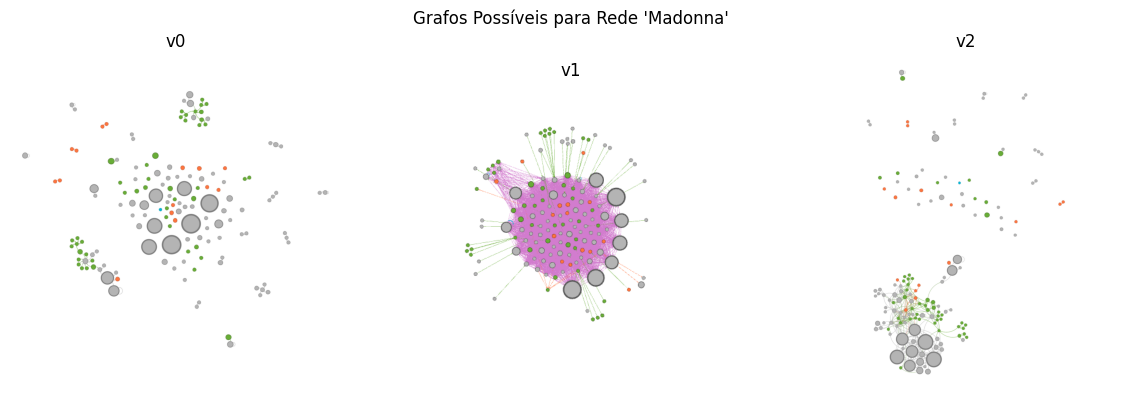

In [60]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img1 = mpimg.imread('madonna_v0.png')
img2 = mpimg.imread('print_madonna_v1.png')
img3 = mpimg.imread('madonna_v2.png')

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

imagens = [img1, img2, img3]
titulos = ['v0', 'v1', 'v2']

fig.suptitle("Grafos Possíveis para Rede 'Madonna'", fontsize=12)

# Plota cada imagem com título
for ax, img, titulo in zip(axs, imagens, titulos):
    ax.imshow(img)
    ax.set_title(titulo)
    ax.axis('off')

plt.tight_layout()
plt.show()


#### Análise da Rede

In [73]:
G = nx.DiGraph()
G = nx.read_gexf("madonna_v2.gexf")
G_undirected = nx.DiGraph(G).to_undirected(as_view=False)
# G_undirected = G.to_undirected()

In [74]:
G.number_of_nodes()

151

In [75]:
G.number_of_edges()

340

#####**Visualização**

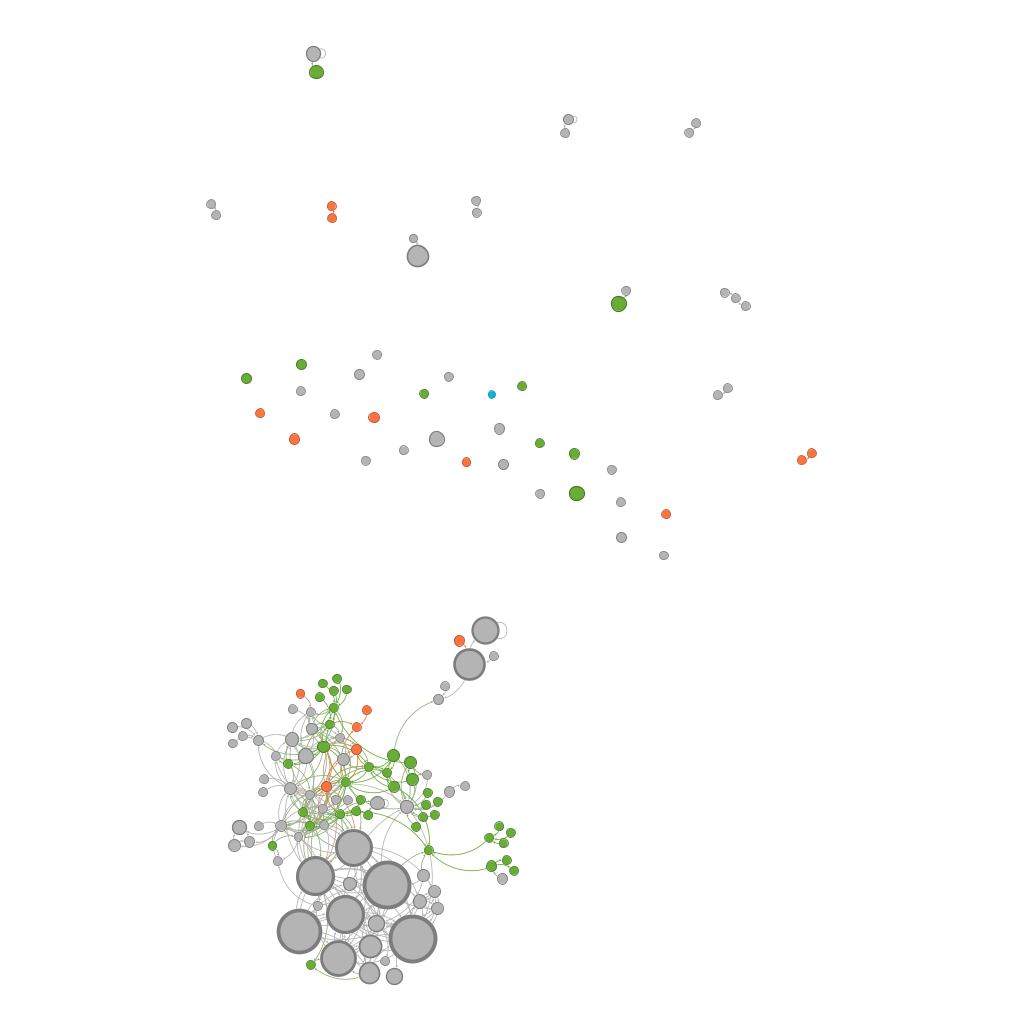

##### **Distribuição do grau dos nodos desse grafo e grau médio do grafo**

Grau médio: 4.50



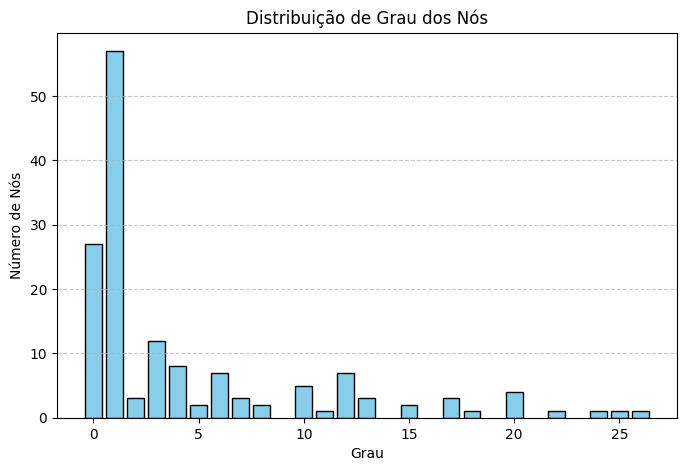

In [64]:
# 1. Calcular o grau de cada nó
graus = [grau for _, grau in G.degree()]

# 2. Calcular o grau médio
grau_medio = sum(graus) / len(graus)
print(f"Grau médio: {grau_medio:.2f}\n")

# 3. Calcular a distribuição do grau
from collections import Counter
contagem_graus = Counter(graus)

# 4. Ordenar os graus para o gráfico
graus_ordenados = sorted(contagem_graus.items())
x, y = zip(*graus_ordenados)

# 5. Plotar a distribuição
plt.figure(figsize=(8, 5))
plt.bar(x, y, width=0.80, color='skyblue', edgecolor='black')
plt.title('Distribuição de Grau dos Nós')
plt.xlabel('Grau')
plt.ylabel('Número de Nós')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### **Número de componentes do grafo**

In [65]:
# Número de componentes conectados
n_conectados = nx.number_connected_components(G_undirected)
print(f"Número de componentes conectados: {n_conectados}")

Número de componentes conectados: 39


##### **Coeficiente de clusterização de cada nodo e também o coeficiente de clusterização global do grafo**

Coeficiente de clusterização global: 0.2607


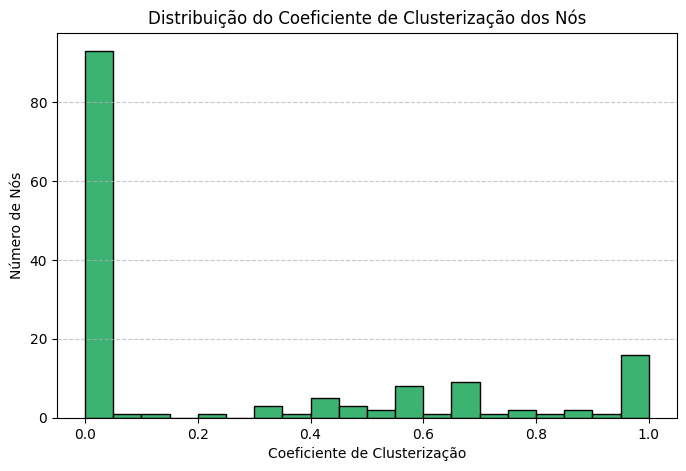

In [66]:
# Coeficiente de clusterização de cada nó
clustering_nodes = nx.clustering(G_undirected)
valores_cluster = list(clustering_nodes.values())

# Coeficiente de clusterização global
clustering_global = nx.average_clustering(G_undirected)
print(f"Coeficiente de clusterização global: {clustering_global:.4f}")

# Plotar a distribuição dos coeficientes locais
plt.figure(figsize=(8, 5))
plt.hist(valores_cluster, bins=20, color='mediumseagreen', edgecolor='black')
plt.title('Distribuição do Coeficiente de Clusterização dos Nós')
plt.xlabel('Coeficiente de Clusterização')
plt.ylabel('Número de Nós')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### **Distribuição do tamanho dos componentes do grafo**

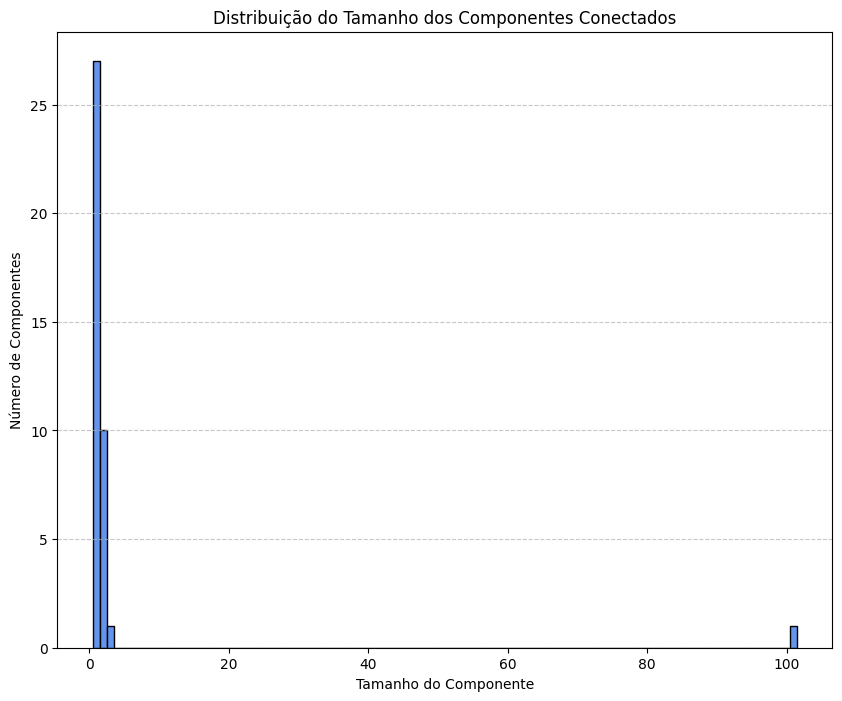

In [67]:
# Obter componentes conectados
componentes = list(nx.connected_components(G_undirected))

# Verificar se há mais de um componente
if len(componentes) > 1:
    # Calcular tamanhos
    tamanhos = [len(c) for c in componentes]

    # Plotar distribuição
    plt.figure(figsize=(10, 8))
    plt.hist(tamanhos, bins=range(1, max(tamanhos)+2), align='left',
             color='cornflowerblue', edgecolor='black')
    plt.title('Distribuição do Tamanho dos Componentes Conectados')
    plt.xlabel('Tamanho do Componente')
    plt.ylabel('Número de Componentes')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("O grafo possui apenas um componente. Nada a plotar.")

##### **Overlap da vizinhança para cada par de nodo**

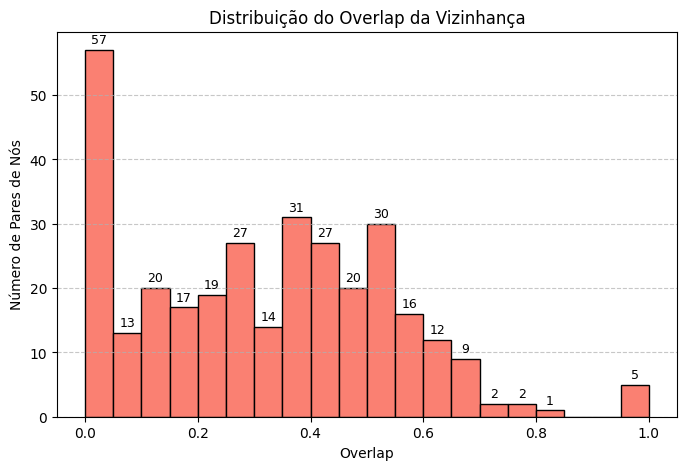

In [68]:
# Função para calcular o overlap da vizinhança
def calcular_overlap(G, u, v):
    viz_u = set(G.neighbors(u))
    viz_v = set(G.neighbors(v))
    inter = viz_u & viz_v
    union = viz_u | viz_v
    return len(inter) / len(union) if union else 0

# Calcular overlap para cada par de nós conectados
overlaps = []
for u, v in G_undirected.edges():
    overlaps.append(calcular_overlap(G_undirected, u, v))

# Plotar distribuição
plt.figure(figsize=(8, 5))
counts, bins, patches = plt.hist(overlaps, bins=20, color='salmon', edgecolor='black')

for count, patch in zip(counts, patches):
    x = patch.get_x() + patch.get_width() / 2
    y = count
    if y > 0:
        plt.text(x, y + 0.5, int(y), ha='center', va='bottom', fontsize=9)

plt.title('Distribuição do Overlap da Vizinhança')
plt.xlabel('Overlap')
plt.ylabel('Número de Pares de Nós')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


##### **Distância média e a distribuição das distâncias de todos os nodos da rede.**

Distância média: 3.30



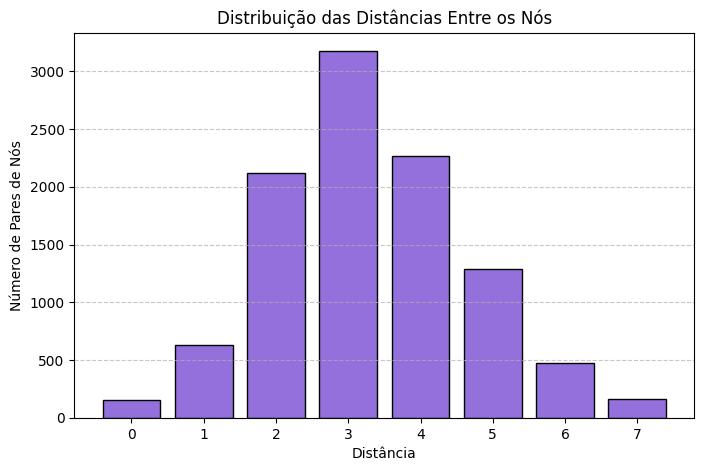

In [69]:
# Calcular todas as distâncias mais curtas
caminhos = dict(nx.all_pairs_shortest_path_length(G_undirected))

# Coletar todas as distâncias em uma lista
distancias = []
for dists in caminhos.values():
    distancias.extend(dists.values())

# Calcular distância média
distancia_media = sum(distancias) / len(distancias)
print(f"Distância média: {distancia_media:.2f}\n")

# Distribuição das distâncias
contagem = Counter(distancias)
x, y = zip(*sorted(contagem.items()))

# Plotar a distribuição
plt.figure(figsize=(8, 5))
plt.bar(x, y, color='mediumpurple', edgecolor='black')
plt.title('Distribuição das Distâncias Entre os Nós')
plt.xlabel('Distância')
plt.ylabel('Número de Pares de Nós')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Show da Lady Gaga

#### Coleta dos Dados

O show da Lady Gaga ocorreu no dia 03/05/2025. Para a coleta, vamos considerar um mês antes e um mês depois do show.

In [76]:
#data do show = 03/05/2025
DATA_INICIO = datetime(2025, 4, 3, tzinfo=timezone.utc)
DATA_FIM = datetime(2025, 6, 3, tzinfo=timezone.utc)

A seleção dos posts foi feita utilizando filtros por hashtags e por termos presentes no conteúdo textual das publicações.

As hashtags e termos utilizados na coleta foram definidos de maneira exploratória com o objetivo de captar publicações com alto grau de associação explícita aos shows.

##### Toots [posts]

In [77]:
hashtags_coleta = ["LadyGaga", "Gaga"] # hashtags a serem buscadas
palavras_chave = ["gaga"] # termos que devem aparecer no texto do toot

In [78]:
toots_coletados = []
ids_coletados = set()

for hashtag in hashtags_coleta:
    print(f"Buscando por #{hashtag}...", end='')
    count = 0
    max_id = None
    while True:
        toots = mastodon.timeline_hashtag(hashtag, max_id=max_id, limit=50)
        if not toots:
            break

        for toot in toots:
            data = toot['created_at']
            texto = html.unescape(toot['content']).lower()
            if data < DATA_INICIO:
                break
            if DATA_INICIO <= data <= DATA_FIM:
                if all(palavra in texto for palavra in palavras_chave):
                    if toot['id'] not in ids_coletados:
                        toots_coletados.append(toot)
                        ids_coletados.add(toot['id'])
                        count += 1

        max_id = toots[-1]['id']
        time.sleep(1)
    print(f'{count} toots')

print(f"\nTotal de toots coletados: {len(toots_coletados)}")

Buscando por #LadyGaga...572 toots
Buscando por #Gaga...23 toots

Total de toots coletados: 595


In [79]:
with open("toots_gaga.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=toots_coletados[0].keys(), quoting=csv.QUOTE_ALL)
    writer.writeheader()
    writer.writerows(toots_coletados)

print("Arquivo CSV salvo como 'toots_gaga.csv'")

Arquivo CSV salvo como 'toots_gaga.csv'


###### Mapear Usuários que Publicaram Toots

In [80]:
from collections import defaultdict
usuarios = defaultdict(list)

In [81]:
from bs4 import BeautifulSoup
import html
import re

for toot in toots_coletados:
    autor = toot['account']['acct']
    toot_id = toot['id']

    # Conteúdo
    conteudo_html = html.unescape(toot['content'])
    soup = BeautifulSoup(conteudo_html, 'html.parser')
    texto_limpo = soup.get_text(separator=' ').strip()

    # Idioma
    language = toot.get('language')

    usuarios[autor].append({'conteudo': texto_limpo,
                            'idioma': language,
                            'tipo': 'toot',
                            'original_autor': autor,
                            'toot_id':toot_id})

In [82]:
len(usuarios)

177

In [83]:
sum(len(lista) for lista in usuarios.values())

595

##### Interações

Com nossos vértices, agora precisamos coletar as arestas do nosso grafo. Os tipos de interação são:

* boost: usuário A deu boost num toot de B.

[No Mastodon, um boost é equivalente ao retweet do Twitter (ou X). Ele serve para recompartilhar uma publicação (toot) de outra pessoa com todos os seus seguidores, sem fazer alterações no conteúdo original]

* reply: A respondeu um toot de B.

* mention: A mencionou B num toot.

###### Boost

In [84]:
print("Coletando boost...")
interacoes_boost = []
for toot in toots_coletados:
    autor = toot['account']['acct']
    toot_id = toot['id']
    data = toot['created_at'].isoformat()

    conteudo_html = html.unescape(toot['content'])
    soup = BeautifulSoup(conteudo_html, 'html.parser')
    texto_limpo = soup.get_text(separator=' ').strip()

    language = toot['language']

    try:
        boost_users = mastodon.status_reblogged_by(toot_id)
        for u in boost_users:
            user = u['acct']
            interacoes_boost.append({'de': u['acct'], 'para': autor, 'tipo': 'boost', 'data': data})

            #adicionar ao usuário que deu boost no toot, as informações sobre o toot
            usuarios[user].append({'conteudo': texto_limpo,
                                    'idioma': language,
                                    'tipo': 'boost',
                                    'original_autor': autor,
                                    'toot_id':toot_id})
        time.sleep(1)
    except Exception as e:
        print(f"Erro boost toot {toot_id}: {e}")
print(len(interacoes_boost), 'boosts coletados')

Coletando boost...
Erro boost toot 114541653937478763: ('Mastodon API returned error', 503, 'Service Unavailable', None)
Erro boost toot 114430746314357259: ('Mastodon API returned error', 503, 'Service Unavailable', None)
156 boosts coletados


###### Mention

In [85]:
import re

print("Coletando mention...")
interacoes_mention = []
for toot in toots_coletados:
    autor = toot['account']['acct']
    toot_id = toot['id']
    data = toot['created_at'].isoformat()

    conteudo_html = html.unescape(toot['content'])
    soup = BeautifulSoup(conteudo_html, 'html.parser')
    texto_limpo = soup.get_text(separator=' ').strip()

    language = toot['language']

    mentions = re.findall(r'@([\w@.\-]+)', conteudo_html)
    for m in mentions:
        if m != autor:
            interacoes_mention.append({'de': autor, 'para': m, 'tipo': 'mention', 'data': data})

            usuarios[m].append({'conteudo': texto_limpo,
                                            'idioma': language,
                                            'tipo': 'mention',
                                            'original_autor': autor,
                                            'toot_id':toot_id})

print(len(interacoes_mention), 'menções coletadas')

Coletando mention...
36 menções coletadas


###### Reply

In [86]:
interacoes_reply = []

print("Coletando reply...")
for toot in toots_coletados:
    autor = toot['account']['acct']
    toot_id = toot['id']
    data = toot['created_at'].isoformat()

    # toot['in_reply_to_id']: ID do toot ao qual este toot é uma resposta.
    # toot['in_reply_to_account_id']: ID da conta à qual o toot respondido pertence (o autor do toot original).

    if toot['in_reply_to_account_id']:
        try:
            alvo = mastodon.account(toot['in_reply_to_account_id'])['acct']
            interacoes_reply.append({'de': autor, 'para': alvo, 'tipo': 'reply', 'data': data})

            #coleta o toot original respondido
            toot_respondido = mastodon.status(toot['in_reply_to_id'])
            conteudo_respondido = BeautifulSoup(html.unescape(toot_respondido['content']), 'html.parser').get_text(separator=' ').strip()
            language = toot_respondido.get('language')

            usuarios[alvo].append({'conteudo': conteudo_respondido,
                                         'idioma': language,
                                         'tipo': 'reply',
                                         'original_autor': autor, #autor da resposta
                                         'toot_id':toot['in_reply_to_id']})


        except:
            pass

print(len(interacoes_reply), 'respostas coletadas')

Coletando reply...
44 respostas coletadas


###### Novos Usuários Envolvidos

In [87]:
len(usuarios)

292

In [88]:
tipos_total = Counter()

for lista in usuarios.values():
    for toot in lista:
        tipos_total[toot['tipo']] += 1

for tipo, count in tipos_total.items():
    print(f"{tipo}: {count}")

toot: 595
reply: 44
boost: 156
mention: 36


##### Hashtags em Comum

In [89]:
from itertools import combinations
from collections import defaultdict
import html

import re
hashtags_em_comum = []

# Dicionário para mapear hashtags aos autores
hashtags_autores = defaultdict(set)

for toot in toots_coletados:
    autor = toot['account']['acct']
    toot_id = toot['id']
    data = toot['created_at'].isoformat()
    conteudo = html.unescape(toot['content'])

    hashtags = [tag['name'].lower() for tag in toot.get('tags', [])]
    for h in hashtags:
        hashtags_autores[h].add(autor)

# arestas não direcionadas entre autores que usaram a mesma hashtag
for hashtag, autores in hashtags_autores.items():
    for u1, u2 in combinations(autores, 2):
        hashtags_em_comum.append({'de': u1, 'para': u2, 'tipo':'hashtag', 'data':hashtag})

In [90]:
len(hashtags_em_comum)

14975

Agora temos um exagero de arestas, pois usamos o filtro de coleta para interligar os usuários. Por isso, também vamos avaliar a abordagem de considerar as hashtags em comum que não foram usadas na coleta.

In [91]:
for tag in hashtags_coleta:
  print(tag.lower())

ladygaga
gaga


In [92]:
for tag in hashtags_coleta:
    hashtags_autores.pop(tag.lower(), None)  # remove se existir, ignora se não existir

In [93]:
hashtags_em_comum_diferentes_coleta = []

for hashtag, autores in hashtags_autores.items():
    for u1, u2 in combinations(autores, 2):
        hashtags_em_comum_diferentes_coleta.append({'de': u1, 'para': u2, 'tipo':'hashtag', 'data':hashtag})

In [94]:
len(hashtags_em_comum_diferentes_coleta)

1309

#### Construção da Rede

##### Nós = Usuários

Como os nós da rede são os usuários que postaram algum toot ou que interarigam com algum toot relacionado ao show, vamos enriquecer nossa rede com informações sobre o usuário considerando inclusive o conteúdo dos toots

In [95]:
len(usuarios)

292

###### informações sobre a conta do usuário

In [96]:
def coletar_info_usuario(acct):
    try:
        user = mastodon.account_lookup(acct)

        info = {
            'id': str(user.id),
            'acct': str(user.acct),
            'created_at': str(user.created_at.isoformat()) if user.created_at else str(None),
            'followers_count': str(user.followers_count),
            'following_count': str(user.following_count),
            'statuses_count': str(user.statuses_count),
            'last_status_at': str(user.last_status_at),
            'group': str(user.group),
            'discoverable': str(user.discoverable),
            'locked': str(user.locked)
        }
        return info

    except Exception as e:
        print(f"Erro ao buscar usuário {acct}: {e}")
        info = {
            'id': str(None),
            'acct': str(acct),
            'created_at': str(None),
            'followers_count': str(None),
            'following_count': str(None),
            'statuses_count': str(None),
            'last_status_at': str(None),
            'group': str(None),
            'discoverable': str(None),
            'locked': str(None)
        }
        return info

In [97]:
def limpar_valores(info):
    return {k: (str(v) if v is not None else 'None') for k, v in info.items()}

###### informações sobre o conteúdos os toots relacionados ao usuário

In [98]:
!pip install -U pysentimiento

In [99]:
from pysentimiento import create_analyzer
analyzer_es = create_analyzer(task="sentiment", lang="es")
analyzer_en = create_analyzer(task="sentiment", lang="en")
analyzer_pt = create_analyzer(task="sentiment", lang="pt")

In [100]:
from collections import defaultdict, Counter
from textblob import TextBlob

resumo_conteudo_usuario = {}

for usuario, interacoes in usuarios.items():
    idiomas = []
    sentimentos = []

    for item in interacoes:
        texto = item['conteudo']
        idioma = item.get('idioma', 'desconhecido')
        idiomas.append(idioma)

        if idioma == 'es':
          analyzer = analyzer_es
        elif idioma == 'pt':
          analyzer = analyzer_pt
        else:
          analyzer = analyzer_en

        sentimento = analyzer.predict(texto).output
        sentimentos.append(sentimento)

    idioma_mais_frequente = Counter(idiomas).most_common(1)[0][0] if idiomas else "desconhecido"
    sentimento_mais_frequente = Counter(sentimentos).most_common(1)[0][0] if sentimentos else "indefinido"

    resumo_conteudo_usuario[usuario] = {
        'idioma_mais_frequente': idioma_mais_frequente,
        'sentimento_mais_frequente': sentimento_mais_frequente,
        'total_conteudos': len(interacoes),
    }

In [101]:
len(resumo_conteudo_usuario)

292

In [102]:
from collections import Counter

total_conteudos = 0
idiomas = Counter()
sentimentos = Counter()

for dados in resumo_conteudo_usuario.values():
    idioma = dados['idioma_mais_frequente']
    sentimento = dados['sentimento_mais_frequente']
    total = dados['total_conteudos']

    total_conteudos += total
    idiomas[idioma] += total
    sentimentos[sentimento] += total

print(f"🟢 Total de conteúdos: {total_conteudos}\n")

print("📊 Conteúdos por idioma:")
for idioma, count in idiomas.items():
    print(f"  {idioma}: {count}")

print("\n📈 Conteúdos por sentimento:")
for sentimento, count in sentimentos.items():
    print(f"  {sentimento}: {count}")

🟢 Total de conteúdos: 831

📊 Conteúdos por idioma:
  en: 394
  es: 66
  ca: 2
  nl: 8
  None: 12
  pt: 265
  de: 25
  fr: 30
  pl: 3
  ko: 5
  ja: 10
  tr: 2
  it: 3
  ro: 1
  uk: 2
  zh-TW: 3

📈 Conteúdos por sentimento:
  NEU: 680
  POS: 122
  NEG: 29


###### dicionário completo

In [103]:
info_adicionais = {}
for acct, resumo in resumo_conteudo_usuario.items():
    info = coletar_info_usuario(acct)

    info.update({
        'idioma_mais_frequente': resumo.get('idioma_mais_frequente'),
        'sentimento_mais_frequente': resumo.get('sentimento_mais_frequente'),
        'total_conteudos': resumo.get('total_conteudos')
    })

    info_limpo = limpar_valores(info)
    info_adicionais[acct] = info_limpo

Erro ao buscar usuário TheConversationUS: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário lesmusicultes: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário matematico314: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário matematico: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário PedroRonchi2: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário coletivoosfofos.bsky.social: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário brasil247.bsky.social: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário calotaspolares: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')
Erro ao buscar usuário radiocorsa_br: ('Mastodon API returned error', 404, 'Not Found', 'Record not found')


In [104]:
len(info_adicionais)

292

In [105]:

with open("info_usuarios_gaga.json", "w", encoding="utf-8") as f:
    json.dump(info_adicionais, f, ensure_ascii=False, indent=2)

##### Arestas = Interações + Hashtags em Comum

In [106]:
versao_0 = interacoes_boost + interacoes_mention + interacoes_reply
versao_1 = interacoes_boost + interacoes_mention + interacoes_reply + hashtags_em_comum
versao_2 = interacoes_boost + interacoes_mention + interacoes_reply + hashtags_em_comum_diferentes_coleta

##### Grafos Possíveis

In [107]:
import networkx as nx

###### Grafo_v0

In [108]:
G_v0 = nx.DiGraph()

for acct, info_user in info_adicionais.items():
    G_v0.add_node(acct, **info_user)

In [109]:
G_v0.number_of_nodes()

292

In [110]:
G_v0.number_of_edges()

0

In [111]:
for aresta in versao_0:
  if aresta['de'] in G_v0.nodes() and aresta['para'] in G_v0.nodes():
    G_v0.add_edge(aresta['de'], aresta['para'], tipo=aresta['tipo'], data=aresta['tipo'])
  else:
    print(aresta)

In [112]:
G_v0.number_of_nodes()

292

In [113]:
G_v0.number_of_edges()

166

In [114]:
nx.write_gexf(G_v0, 'gaga_v0.gexf')

###### Grafo_v1

In [115]:
G_v1 = nx.DiGraph()

for acct, info_user in info_adicionais.items():
    G_v1.add_node(acct, **info_user)

In [116]:
G_v1.number_of_nodes()

292

In [117]:
G_v1.number_of_edges()

0

In [118]:
for aresta in versao_1:
  if aresta['de'] in G_v1.nodes() and aresta['para'] in G_v1.nodes():
    G_v1.add_edge(aresta['de'], aresta['para'], tipo=aresta['tipo'], data=aresta['tipo'])
  else:
    print(aresta)

In [119]:
G_v1.number_of_nodes()

292

In [120]:
G_v1.number_of_edges()

14234

In [121]:
nx.write_gexf(G_v1, 'gaga_v1.gexf')

###### Grafo_v2

In [122]:
G_v2 = nx.DiGraph()

for acct, info_user in info_adicionais.items():
    G_v2.add_node(acct, **info_user)

In [123]:
G_v2.number_of_nodes()

292

In [124]:
G_v2.number_of_edges()

0

In [125]:
for aresta in versao_2:
  if aresta['de'] in G_v2.nodes() and aresta['para'] in G_v2.nodes():
    G_v2.add_edge(aresta['de'], aresta['para'], tipo=aresta['tipo'], data=aresta['tipo'])
  else:
    print(aresta)

In [126]:
G_v2.number_of_nodes()

292

In [127]:
G_v2.number_of_edges()

1169

In [128]:
nx.write_gexf(G_v2, 'gaga_v2.gexf')

###### Visualização

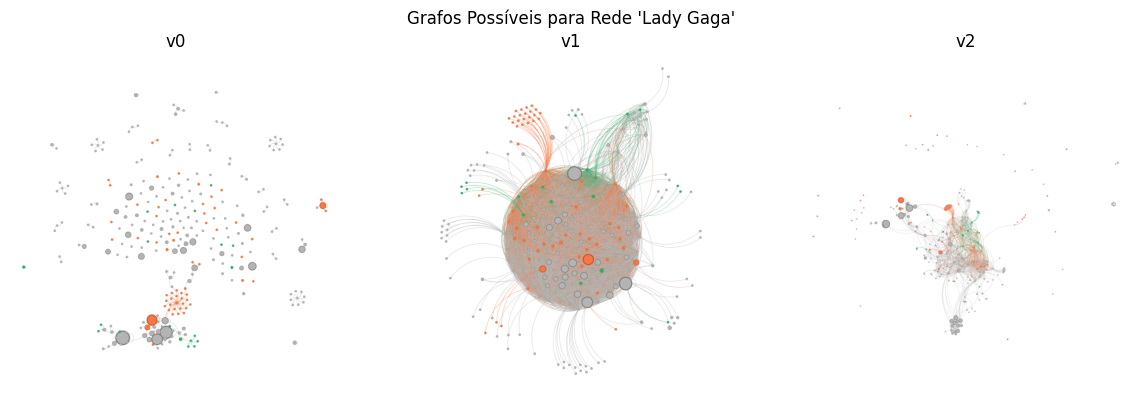

In [129]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img1 = mpimg.imread('gaga_v0.png')
img2 = mpimg.imread('gaga_v1.png')
img3 = mpimg.imread('gaga_v2.png')

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

imagens = [img1, img2, img3]
titulos = ['v0', 'v1', 'v2']

fig.suptitle("Grafos Possíveis para Rede 'Lady Gaga'", fontsize=12)

# Plota cada imagem com título
for ax, img, titulo in zip(axs, imagens, titulos):
    ax.imshow(img)
    ax.set_title(titulo)
    ax.axis('off')

plt.tight_layout()
plt.show()


#### Análise da Rede

In [130]:
G = nx.read_gexf("gaga_v2.gexf")
G_undirected = nx.DiGraph(G).to_undirected(as_view=False)
# G_undirected = G.to_undirected()

In [131]:
G.number_of_nodes()

283

In [132]:
G.number_of_edges()

1169

#####**Visualização**

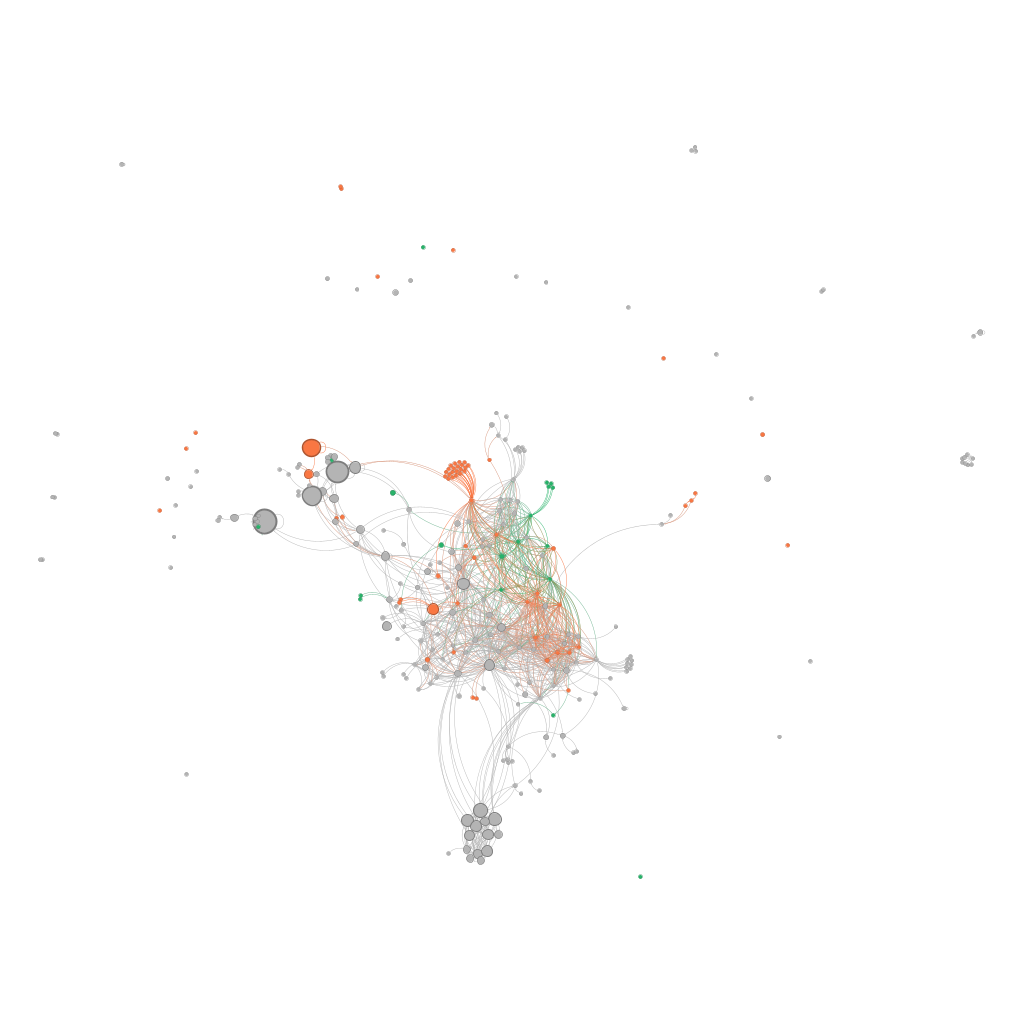

##### **Distribuição do grau dos nodos desse grafo e grau médio do grafo**

Grau médio: 8.26



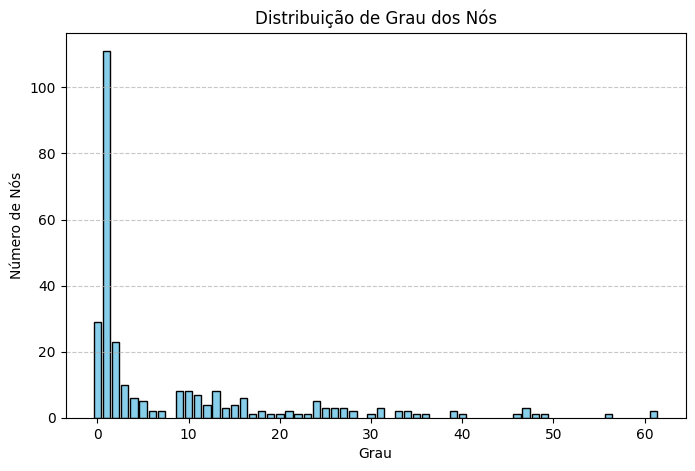

In [133]:
# 1. Calcular o grau de cada nó
graus = [grau for _, grau in G.degree()]

# 2. Calcular o grau médio
grau_medio = sum(graus) / len(graus)
print(f"Grau médio: {grau_medio:.2f}\n")

# 3. Calcular a distribuição do grau
from collections import Counter
contagem_graus = Counter(graus)

# 4. Ordenar os graus para o gráfico
graus_ordenados = sorted(contagem_graus.items())
x, y = zip(*graus_ordenados)

# 5. Plotar a distribuição
plt.figure(figsize=(8, 5))
plt.bar(x, y, width=0.80, color='skyblue', edgecolor='black')
plt.title('Distribuição de Grau dos Nós')
plt.xlabel('Grau')
plt.ylabel('Número de Nós')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### **Número de componentes do grafo**

In [134]:
# Número de componentes conectados
n_conectados = nx.number_connected_components(G_undirected)
print(f"Número de componentes conectados: {n_conectados}")

Número de componentes conectados: 39


##### **Coeficiente de clusterização de cada nodo e também o coeficiente de clusterização global do grafo**

Coeficiente de clusterização global: 0.2866


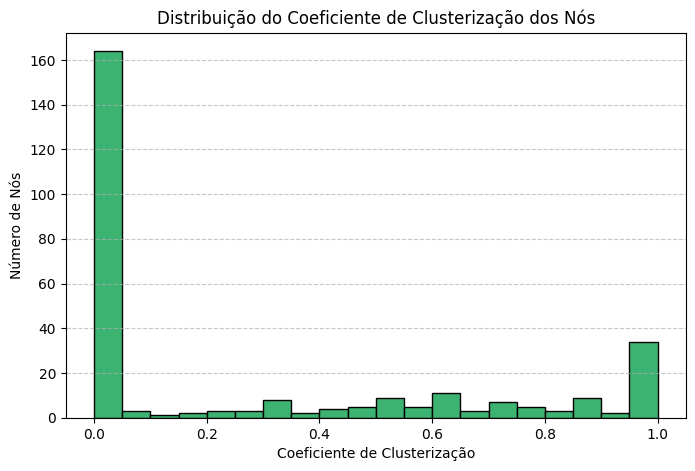

In [135]:
# Coeficiente de clusterização de cada nó
clustering_nodes = nx.clustering(G_undirected)
valores_cluster = list(clustering_nodes.values())

# Coeficiente de clusterização global
clustering_global = nx.average_clustering(G_undirected)
print(f"Coeficiente de clusterização global: {clustering_global:.4f}")

# Plotar a distribuição dos coeficientes locais
plt.figure(figsize=(8, 5))
plt.hist(valores_cluster, bins=20, color='mediumseagreen', edgecolor='black')
plt.title('Distribuição do Coeficiente de Clusterização dos Nós')
plt.xlabel('Coeficiente de Clusterização')
plt.ylabel('Número de Nós')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### **Distribuição do tamanho dos componentes do grafo**

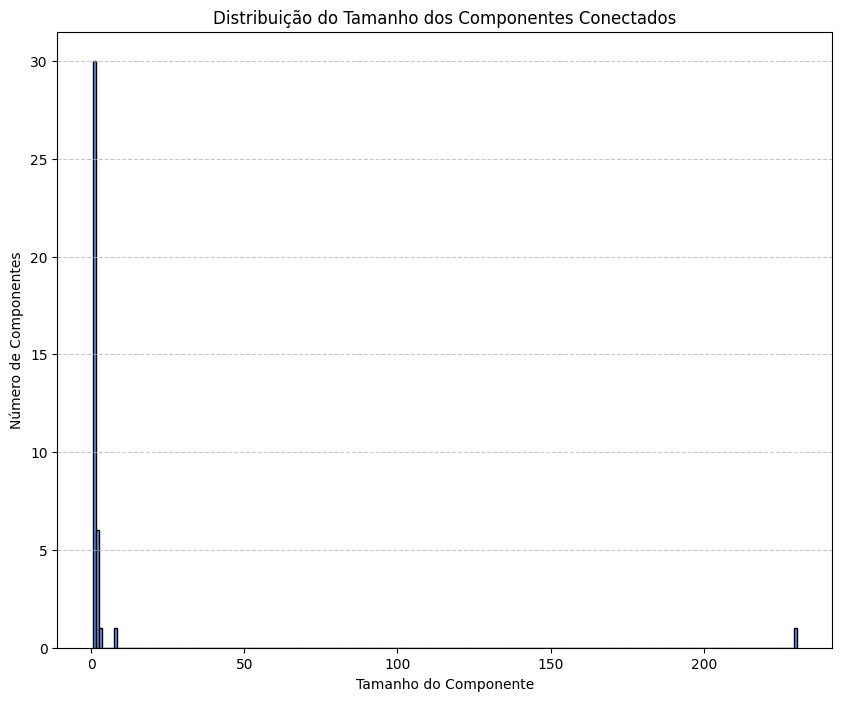

In [136]:
# Obter componentes conectados
componentes = list(nx.connected_components(G_undirected))

# Verificar se há mais de um componente
if len(componentes) > 1:
    # Calcular tamanhos
    tamanhos = [len(c) for c in componentes]

    # Plotar distribuição
    plt.figure(figsize=(10, 8))
    plt.hist(tamanhos, bins=range(1, max(tamanhos)+2), align='left',
             color='cornflowerblue', edgecolor='black')
    plt.title('Distribuição do Tamanho dos Componentes Conectados')
    plt.xlabel('Tamanho do Componente')
    plt.ylabel('Número de Componentes')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("O grafo possui apenas um componente. Nada a plotar.")

##### **Overlap da vizinhança para cada par de nodo**

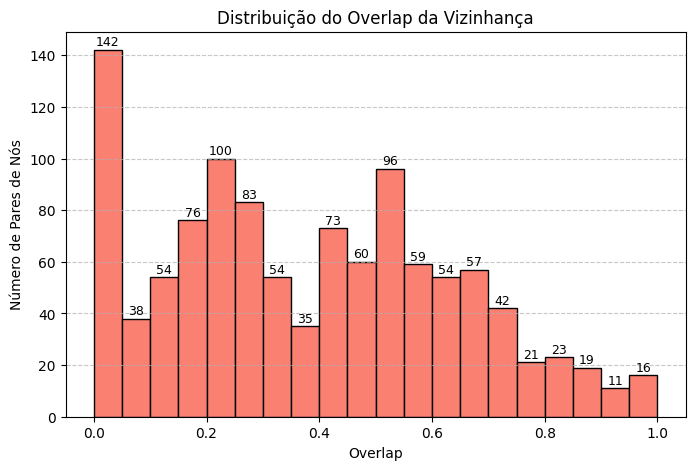

In [137]:
# Função para calcular o overlap da vizinhança
def calcular_overlap(G, u, v):
    viz_u = set(G.neighbors(u))
    viz_v = set(G.neighbors(v))
    inter = viz_u & viz_v
    union = viz_u | viz_v
    return len(inter) / len(union) if union else 0

# Calcular overlap para cada par de nós conectados
overlaps = []
for u, v in G_undirected.edges():
    overlaps.append(calcular_overlap(G_undirected, u, v))

# Plotar distribuição
plt.figure(figsize=(8, 5))
counts, bins, patches = plt.hist(overlaps, bins=20, color='salmon', edgecolor='black')

for count, patch in zip(counts, patches):
    x = patch.get_x() + patch.get_width() / 2
    y = count
    if y > 0:
        plt.text(x, y + 0.5, int(y), ha='center', va='bottom', fontsize=9)

plt.title('Distribuição do Overlap da Vizinhança')
plt.xlabel('Overlap')
plt.ylabel('Número de Pares de Nós')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


##### **Distância média e a distribuição das distâncias de todos os nodos da rede.**

Distância média: 3.28



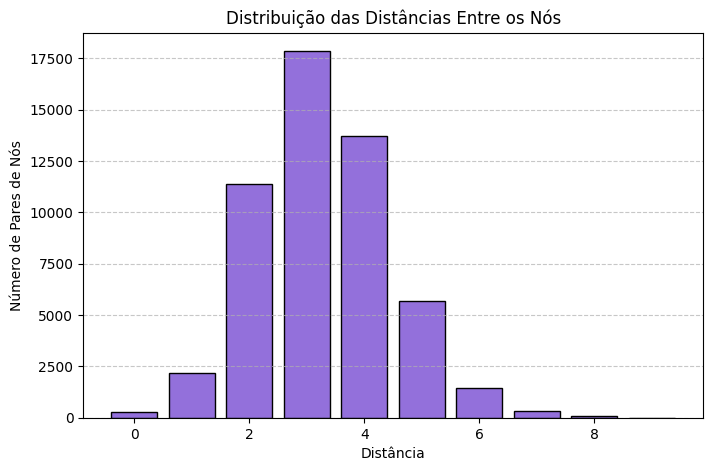

In [138]:
# Calcular todas as distâncias mais curtas
caminhos = dict(nx.all_pairs_shortest_path_length(G_undirected))

# Coletar todas as distâncias em uma lista
distancias = []
for dists in caminhos.values():
    distancias.extend(dists.values())

# Calcular distância média
distancia_media = sum(distancias) / len(distancias)
print(f"Distância média: {distancia_media:.2f}\n")

# Distribuição das distâncias
contagem = Counter(distancias)
x, y = zip(*sorted(contagem.items()))

# Plotar a distribuição
plt.figure(figsize=(8, 5))
plt.bar(x, y, color='mediumpurple', edgecolor='black')
plt.title('Distribuição das Distâncias Entre os Nós')
plt.xlabel('Distância')
plt.ylabel('Número de Pares de Nós')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Análise Comparativa

In [139]:
G_madonna = nx.read_gexf("madonna_v2.gexf") #Carregar arquivo com nx.DiGraph() salvo
G1 = nx.DiGraph(G_madonna).to_undirected(as_view=False)

In [140]:
G_ladygaga = nx.read_gexf("gaga_v2.gexf") #Carregar arquivo com nx.DiGraph() salvo
G2 = nx.DiGraph(G_ladygaga).to_undirected(as_view=False)

In [141]:
import networkx as nx

print("                 Rede Madonna | Rede Lady Gaga")
print("Nós:            ", nx.number_of_nodes(G1), "         |", nx.number_of_nodes(G2))
print("Arestas:        ", nx.number_of_edges(G1), "         |", nx.number_of_edges(G2))
print("Density:        ", round(nx.density(G1), 3), "       |", round(nx.density(G2), 3))
print("Clustering:     ", round(nx.average_clustering(G1), 3), "       |", round(nx.average_clustering(G2), 3))
print("Assortatividade:", round(nx.degree_pearson_correlation_coefficient(G1), 3), "       |", round(nx.degree_pearson_correlation_coefficient(G2), 3))


                 Rede Madonna | Rede Lady Gaga
Nós:             151          | 283
Arestas:         322          | 1113
Density:         0.028        | 0.028
Clustering:      0.261        | 0.287
Assortatividade: 0.224        | 0.108


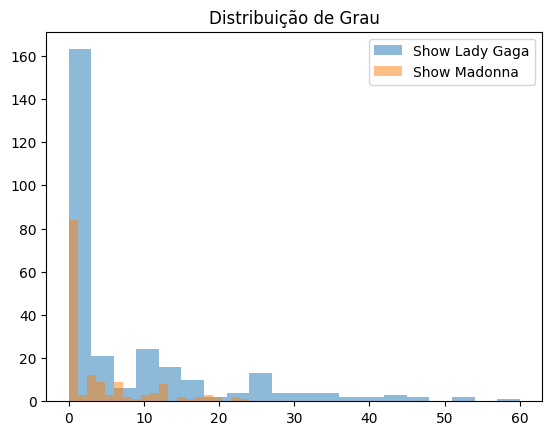

In [142]:
import matplotlib.pyplot as plt

degrees_G1 = [d for n, d in G1.degree()]
degrees_G2 = [d for n, d in G2.degree()]

plt.hist(degrees_G2, bins=20, alpha=0.5, label='Show Lady Gaga')
plt.hist(degrees_G1, bins=20, alpha=0.5, label='Show Madonna')
plt.legend()
plt.title('Distribuição de Grau')
plt.show()


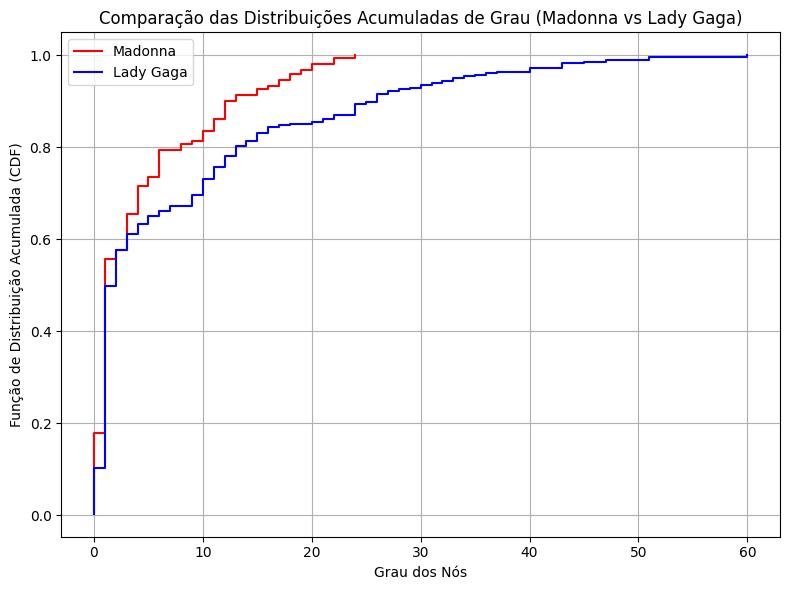

KS-test: estatística=0.137, p-valor=0.045


In [143]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import ks_2samp

# Supondo que G1 = rede Madonna, G2 = rede Lady Gaga
degrees_G1 = np.array([d for n, d in G1.degree()])
degrees_G2 = np.array([d for n, d in G2.degree()])

# Ordenar os graus
sorted_degrees_G1 = np.sort(degrees_G1)
sorted_degrees_G2 = np.sort(degrees_G2)

# Calcular CDFs (funções de distribuição acumulada)
cdf_G1 = np.arange(1, len(sorted_degrees_G1)+1) / len(sorted_degrees_G1)
cdf_G2 = np.arange(1, len(sorted_degrees_G2)+1) / len(sorted_degrees_G2)

# Plotar
plt.figure(figsize=(8, 6))
plt.step(sorted_degrees_G1, cdf_G1, label='Madonna', where='post', color='red')
plt.step(sorted_degrees_G2, cdf_G2, label='Lady Gaga', where='post', color='blue')
plt.xlabel('Grau dos Nós')
plt.ylabel('Função de Distribuição Acumulada (CDF)')
plt.title('Comparação das Distribuições Acumuladas de Grau (Madonna vs Lady Gaga)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# (Opcional) Mostrar o resultado do KS-test no console
stat, p_value = ks_2samp(degrees_G1, degrees_G2)
print(f'KS-test: estatística={stat:.3f}, p-valor={p_value:.3f}')


Esses valores indicam uma tendência de diferença nas distribuições, embora a diferença não seja estatisticamente significativa ao nível convencional de 5%. Isso sugere que os padrões de conectividade dos usuários nas duas redes são similares em termos de distribuição de grau, ainda que a rede Lady Gaga apresente um número absoluto maior de conexões.

In [144]:
overlaps = []
for node in set(G1.nodes()).intersection(G2.nodes()):
    neighbors_G1 = set(G1.neighbors(node))
    neighbors_G2 = set(G2.neighbors(node))
    intersection = len(neighbors_G1 & neighbors_G2)
    union = len(neighbors_G1 | neighbors_G2)
    if union > 0:
        overlaps.append(intersection / union)

import numpy as np
print('Média de Jaccard:', np.mean(overlaps))


Média de Jaccard: 0.15559611235115806


In [145]:
# Conjuntos de arestas (convertendo para tuplas se for grafo não direcionado)
edges_G1 = set(G1.edges())
edges_G2 = set(G2.edges())

# Arestas em comum
common_edges = edges_G1 & edges_G2

# Total de arestas distintas (união das duas redes)
all_edges = edges_G1 | edges_G2

# Métrica de Overlap (Jaccard das arestas)
edge_overlap_ratio = len(common_edges) / len(all_edges)

print(f"Arestas em comum: {len(common_edges)}")
print(f"Total de arestas distintas (união): {len(all_edges)}")
print(f"Overlap de arestas (Jaccard): {edge_overlap_ratio:.3f}")


Arestas em comum: 23
Total de arestas distintas (união): 1412
Overlap de arestas (Jaccard): 0.016


In [146]:
import numpy as np

def spectral_distance(G1, G2):
    from numpy.linalg import eigvalsh
    L1 = nx.laplacian_matrix(G1).toarray()
    L2 = nx.laplacian_matrix(G2).toarray()
    evals1 = np.sort(eigvalsh(L1))
    evals2 = np.sort(eigvalsh(L2))
    min_len = min(len(evals1), len(evals2))
    return np.linalg.norm(evals1[:min_len] - evals2[:min_len])

print(spectral_distance(G1, G2))


81.50349170688412


In [147]:
import community.community_louvain as community_louvain


partition_G1 = community_louvain.best_partition(G1)
partition_G2 = community_louvain.best_partition(G2)

modularity_G1 = community_louvain.modularity(partition_G1, G1)
modularity_G2 = community_louvain.modularity(partition_G2, G2)

print(modularity_G1, modularity_G2)


0.5459665907951083 0.49114039825019834


In [148]:
# Conjuntos de nós de cada rede
nodes_G1 = set(G1.nodes())
nodes_G2 = set(G2.nodes())

# Nós em comum (usuários presentes nas duas redes)
common_nodes = nodes_G1.intersection(nodes_G2)

# Nós exclusivos de cada rede
only_in_G1 = nodes_G1 - nodes_G2
only_in_G2 = nodes_G2 - nodes_G1

# Exibir resultados
print(f"Total de nós na G1: {len(nodes_G1)}")
print(f"Total de nós na G2: {len(nodes_G2)}")
print(f"Nós presentes nas duas redes: {len(common_nodes)}")
print("\nUsuários em comum em ambas as redes:")

for usuario in list(common_nodes):
  print(usuario)

Total de nós na G1: 151
Total de nós na G2: 283
Nós presentes nas duas redes: 33

Usuários em comum em ambas as redes:
112270385225129498
111851866013469467
112400000008841902
109524643919191581
111900428395611467
112220593118747364
112396000153337774
112395925764048952
109344711367429108
111187643456808385
112101255698043880
111185818641423987
None
112304914460621385
112394623530103312
110767005095620731
110900324964412148
109368012017896419
108194890308088987
110895665584209090
110900137009049026
110442944608470608
111341902048546801
110273759047707717
112304978638392761
109363158425896958
111874686067929988
112333797569461150
112395959786955928
112326463086794532
481069
109397303564552333
109302611661107019


In [149]:
import numpy as np
from scipy.stats import pearsonr

common_nodes = set(G1.nodes()) & set(G2.nodes())

degrees_G1 = np.array([G1.degree(n) for n in common_nodes])
degrees_G2 = np.array([G2.degree(n) for n in common_nodes])

corr, p_value = pearsonr(degrees_G1, degrees_G2)
print(f"Correlação dos graus nos usuários comuns: r={corr:.3f}, p={p_value:.3f}")


Correlação dos graus nos usuários comuns: r=0.618, p=0.000


In [150]:
!pip install adjustText


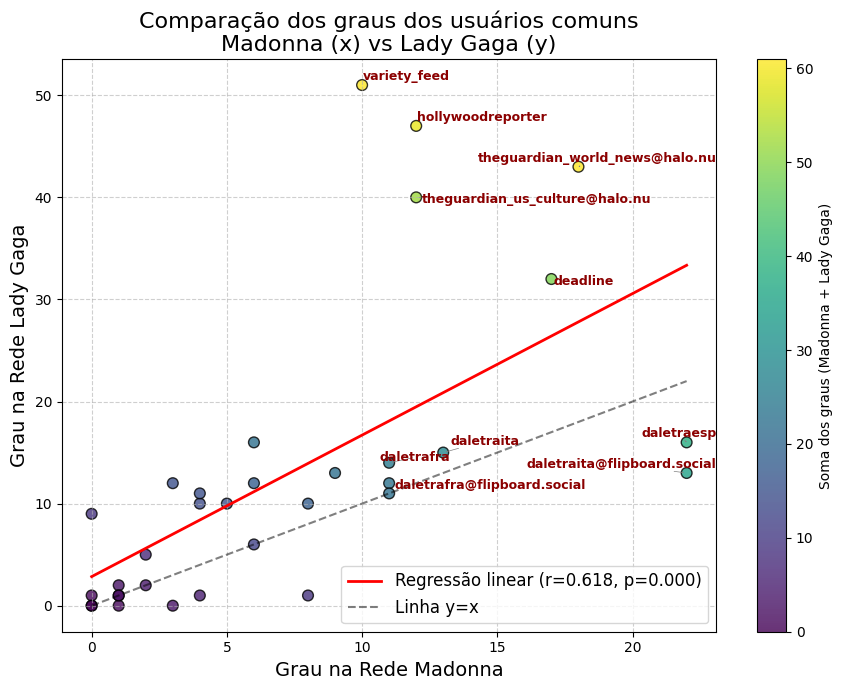

In [170]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from adjustText import adjust_text

common_nodes = list(set(G1.nodes()) & set(G2.nodes()))
degrees_G1 = np.array([G1.degree(n) for n in common_nodes])
degrees_G2 = np.array([G2.degree(n) for n in common_nodes])

plt.figure(figsize=(9,7))
scatter = plt.scatter(degrees_G1, degrees_G2, c=degrees_G1 + degrees_G2, cmap='viridis',
                      alpha=0.8, edgecolor='k', s=60)
plt.colorbar(scatter, label='Soma dos graus (Madonna + Lady Gaga)')

# Regressão linear
slope, intercept, r_value, p_value, std_err = linregress(degrees_G1, degrees_G2)
line_x = np.linspace(0, degrees_G1.max(), 100)
line_y = intercept + slope * line_x
plt.plot(line_x, line_y, 'r-', lw=2, label=f'Regressão linear (r={r_value:.3f}, p={p_value:.3f})')

# Linha y=x como referência
plt.plot(line_x, line_x, 'k--', alpha=0.5, label='Linha y=x')

plt.title('Comparação dos graus dos usuários comuns\nMadonna (x) vs Lady Gaga (y)', fontsize=16)
plt.xlabel('Grau na Rede Madonna', fontsize=14)
plt.ylabel('Grau na Rede Lady Gaga', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Destacar top usuários com maior soma de grau
top_idx = np.argsort(degrees_G1 + degrees_G2)[-10:]
texts = []
for idx in top_idx:
    texts.append(plt.text(degrees_G1[idx], degrees_G2[idx], G1.nodes()[common_nodes[idx]]['acct'],
                          fontsize=9, fontweight='bold', color='darkred'))

# Ajuste automático para evitar sobreposição
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

plt.show()


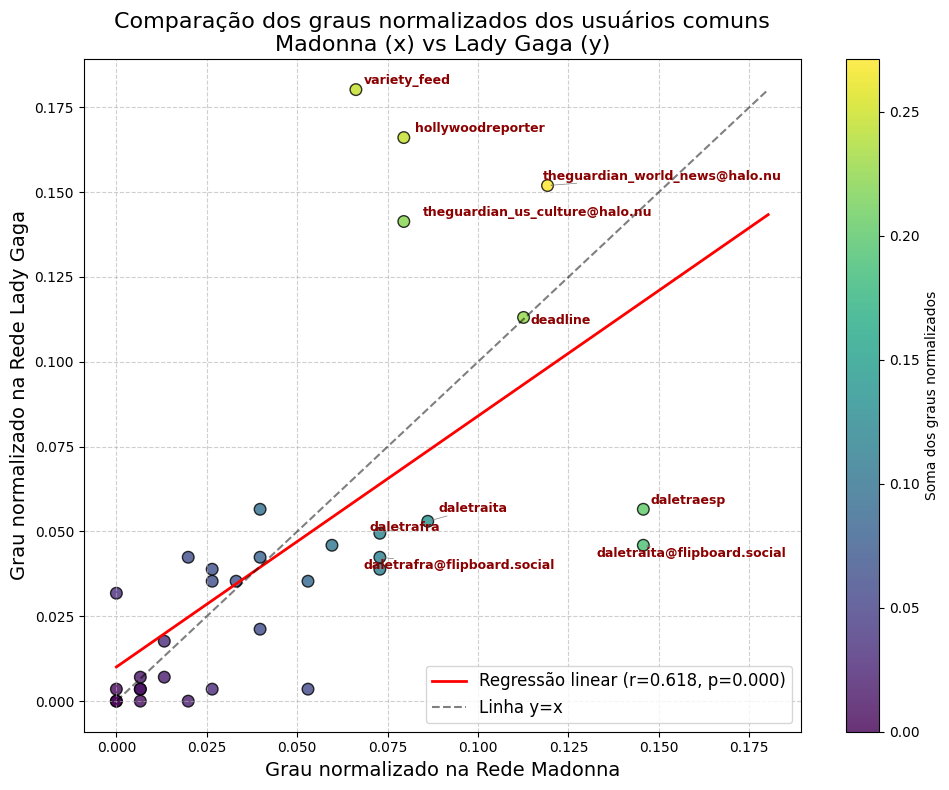

In [171]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from adjustText import adjust_text

common_nodes = list(set(G1.nodes()) & set(G2.nodes()))

num_nodes_G1 = G1.number_of_nodes()
num_nodes_G2 = G2.number_of_nodes()

degrees_G1_norm = np.array([G1.degree(n) / num_nodes_G1 for n in common_nodes])
degrees_G2_norm = np.array([G2.degree(n) / num_nodes_G2 for n in common_nodes])

plt.figure(figsize=(10,8))
scatter = plt.scatter(degrees_G1_norm, degrees_G2_norm,
                      c=degrees_G1_norm + degrees_G2_norm, cmap='viridis',
                      alpha=0.8, edgecolor='k', s=70)
plt.colorbar(scatter, label='Soma dos graus normalizados')

slope, intercept, r_value, p_value, std_err = linregress(degrees_G1_norm, degrees_G2_norm)
line_x = np.linspace(0, max(degrees_G1_norm.max(), degrees_G2_norm.max()), 100)
line_y = intercept + slope * line_x
plt.plot(line_x, line_y, 'r-', lw=2, label=f'Regressão linear (r={r_value:.3f}, p={p_value:.3f})')
plt.plot(line_x, line_x, 'k--', alpha=0.5, label='Linha y=x')

plt.title('Comparação dos graus normalizados dos usuários comuns\nMadonna (x) vs Lady Gaga (y)', fontsize=16)
plt.xlabel('Grau normalizado na Rede Madonna', fontsize=14)
plt.ylabel('Grau normalizado na Rede Lady Gaga', fontsize=14)
plt.legend(fontsize=12, loc='lower right')

plt.grid(True, linestyle='--', alpha=0.6)

# Destacar top 100 usuários, guardar textos para ajuste
top10_idx = np.argsort(degrees_G1_norm + degrees_G2_norm)[-10:]
texts = []
for idx in top10_idx:
    texts.append(plt.text(degrees_G1_norm[idx], degrees_G2_norm[idx], G1.nodes()[common_nodes[idx]]['acct'],
                          fontsize=9, fontweight='bold', color='darkred'))

# Ajustar texto para evitar sobreposição
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

plt.tight_layout()
plt.show()


In [174]:
common_nodes = set(G1.nodes()) & set(G2.nodes())

jaccard_scores = []
for node in common_nodes:
    neighbors_G1 = set(G1.neighbors(node))
    neighbors_G2 = set(G2.neighbors(node))
    union = neighbors_G1 | neighbors_G2
    if len(union) > 0:
        jaccard = len(neighbors_G1 & neighbors_G2) / len(union)
        jaccard_scores.append((node, jaccard))
    else:
        # Caso o nó não tenha vizinhos em nenhuma rede (grau zero)
        jaccard_scores.append((node, 0.0))

# Ordenar do maior para o menor Jaccard
jaccard_scores.sort(key=lambda x: x[1], reverse=True)

print("Top usuários com maior similaridade de vizinhança:")
for user, score in jaccard_scores[:50]:
  if(score>0):
    print(f"{G1.nodes()[user]['acct']}: {score:.3f}")


Top usuários com maior similaridade de vizinhança:
daletrafra@flipboard.social: 0.643
daletraita: 0.556
daletradeu: 0.467
daletrafra: 0.389
daletrabr: 0.385
daletraeng@flipboard.social: 0.375
daletraesp: 0.310
daletraita@flipboard.social: 0.296
daletraeng: 0.294
daletrabr@musician.social: 0.250
daletra@mas.to: 0.250
bbcnews@mastodon.bot: 0.200
daletrabr@flipboard.social: 0.167
variety_feed: 0.070
deadline: 0.065
hollywoodreporter: 0.054
theguardian_world_news@halo.nu: 0.034
theguardian_us_culture@halo.nu: 0.020


In [175]:
# Categorizar
alta = [G1.nodes()[u]['acct'] for u, s in jaccard_scores if s >= 0.4]
media = [G1.nodes()[u]['acct'] for u, s in jaccard_scores if 0.1 <= s < 0.4]
baixa = [G1.nodes()[u]['acct'] for u, s in jaccard_scores if s < 0.1]

print(f"Alta similaridade (≥0.4): {len(alta)} usuários")
print(f"Média similaridade (0.1–0.4): {len(media)} usuários")
print(f"Baixa similaridade (<0.1): {len(baixa)} usuários")

print("\nUsuários com alta similaridade:")
print(alta)

print("\nUsuários com média similaridade:")
print(media)

print("\nUsuários com baixa similaridade:")
print(baixa)

Alta similaridade (≥0.4): 3 usuários
Média similaridade (0.1–0.4): 10 usuários
Baixa similaridade (<0.1): 20 usuários

Usuários com alta similaridade:
['daletrafra@flipboard.social', 'daletraita', 'daletradeu']

Usuários com média similaridade:
['daletrafra', 'daletrabr', 'daletraeng@flipboard.social', 'daletraesp', 'daletraita@flipboard.social', 'daletraeng', 'daletrabr@musician.social', 'daletra@mas.to', 'bbcnews@mastodon.bot', 'daletrabr@flipboard.social']

Usuários com baixa similaridade:
['variety_feed', 'deadline', 'hollywoodreporter', 'theguardian_world_news@halo.nu', 'theguardian_us_culture@halo.nu', 'Betterifyouneil', 'instance-mastodon.world@relay.fedi.buzz', 'iaravps@conversafiada.net', 'steter@mastodon.stevesworld.co', 'crhoy@bots.fedi.cr', 'ItsThatDeafGuy', '50years_music@mastodon.online', 'QuirkyFilms@c.im', 'Lazarou', 'biagoes@ursal.zone', 'kiq@fedibird.com', 'matematico314@social.linux.pizza', 'dunderklumpen80', 'Data_Threads@piaille.fr', 'ordrad@lor.sh']


In [155]:
import networkx as nx
import numpy as np

def network_basic_stats(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    degrees = np.array([d for _, d in G.degree()])
    degree_max = degrees.max()
    degree_mean = degrees.mean()
    clustering_avg = nx.average_clustering(G)
    diameter = None
    if nx.is_connected(G):
        diameter = nx.diameter(G)
    else:
        # Para redes desconexas, pega o maior diâmetro entre componentes conectados
        diameter = max(nx.diameter(c) for c in (G.subgraph(c) for c in nx.connected_components(G)))
    return {
        "n_nodes": n,
        "n_edges": m,
        "degree_max": degree_max,
        "degree_mean": degree_mean,
        "clustering_avg": clustering_avg,
        "diameter": diameter
    }

stats_G1 = network_basic_stats(G1)
stats_G2 = network_basic_stats(G2)

print("Rede Madonna:", stats_G1)
print("Rede Lady Gaga:", stats_G2)


Rede Madonna: {'n_nodes': 151, 'n_edges': 322, 'degree_max': np.int64(24), 'degree_mean': np.float64(4.264900662251655), 'clustering_avg': 0.2607287466189488, 'diameter': 7}
Rede Lady Gaga: {'n_nodes': 283, 'n_edges': 1113, 'degree_max': np.int64(60), 'degree_mean': np.float64(7.865724381625442), 'clustering_avg': 0.28656923545436674, 'diameter': 9}


In [156]:
def degree_centralization(G):
    degrees = np.array([d for _, d in G.degree()])
    max_degree = degrees.max()
    n = len(degrees)
    sum_diff = np.sum(max_degree - degrees)
    max_possible = (n - 1) * (n - 2)
    centralization = sum_diff / max_possible if max_possible > 0 else 0
    return centralization

cent_G1 = degree_centralization(G1)
cent_G2 = degree_centralization(G2)

print(f"Centralização de grau - Rede Madonna: {cent_G1:.4f}")
print(f"Centralização de grau - Rede Lady Gaga: {cent_G2:.4f}")


Centralização de grau - Rede Madonna: 0.1333
Centralização de grau - Rede Lady Gaga: 0.1862


In [157]:
import community.community_louvain as community_louvain


def detect_communities(G):
    # Calcula a partição das comunidades
    partition = community_louvain.best_partition(G)
    # Calcula a modularidade
    modularity = community_louvain.modularity(partition, G)
    return partition, modularity

partition_G1, modularity_G1 = detect_communities(G1)
partition_G2, modularity_G2 = detect_communities(G2)

print(f"Modularidade Rede Madonna: {modularity_G1:.4f}")
print(f"Modularidade Rede Lady Gaga: {modularity_G2:.4f}")

# Quantidade de comunidades
num_communities_G1 = len(set(partition_G1.values()))
num_communities_G2 = len(set(partition_G2.values()))

print(f"Número de comunidades Rede Madonna: {num_communities_G1}")
print(f"Número de comunidades Rede Lady Gaga: {num_communities_G2}")


Modularidade Rede Madonna: 0.5460
Modularidade Rede Lady Gaga: 0.4897
Número de comunidades Rede Madonna: 46
Número de comunidades Rede Lady Gaga: 47


In [158]:
import networkx as nx
import community.community_louvain as community_louvain

def add_attributes_and_export(G, partition, filename):
    # Adiciona a comunidade como atributo
    for node, community in partition.items():
        G.nodes[node]['community'] = community

    # Adiciona grau e clustering como atributos dos nós
    degree_dict = dict(G.degree())
    clustering_dict = nx.clustering(G)

    for node in G.nodes():
        G.nodes[node]['degree'] = degree_dict[node]
        G.nodes[node]['clustering'] = clustering_dict[node]

    # Exporta para GEXF
    nx.write_gexf(G, filename)
    print(f"Arquivo '{filename}' exportado com sucesso!")

# Detectar comunidades (caso ainda não tenha)
partition_G1, modularity_G1 = community_louvain.best_partition(G1), community_louvain.modularity(community_louvain.best_partition(G1), G1)
partition_G2, modularity_G2 = community_louvain.best_partition(G2), community_louvain.modularity(community_louvain.best_partition(G2), G2)

# Exportar
add_attributes_and_export(G1, partition_G1, "rede_madonna_comunidades_atributos.gexf")
add_attributes_and_export(G2, partition_G2, "rede_ladygaga_comunidades_atributos.gexf")


Arquivo 'rede_madonna_comunidades_atributos.gexf' exportado com sucesso!
Arquivo 'rede_ladygaga_comunidades_atributos.gexf' exportado com sucesso!


Comunidades Rede Complexa Show da Madonna

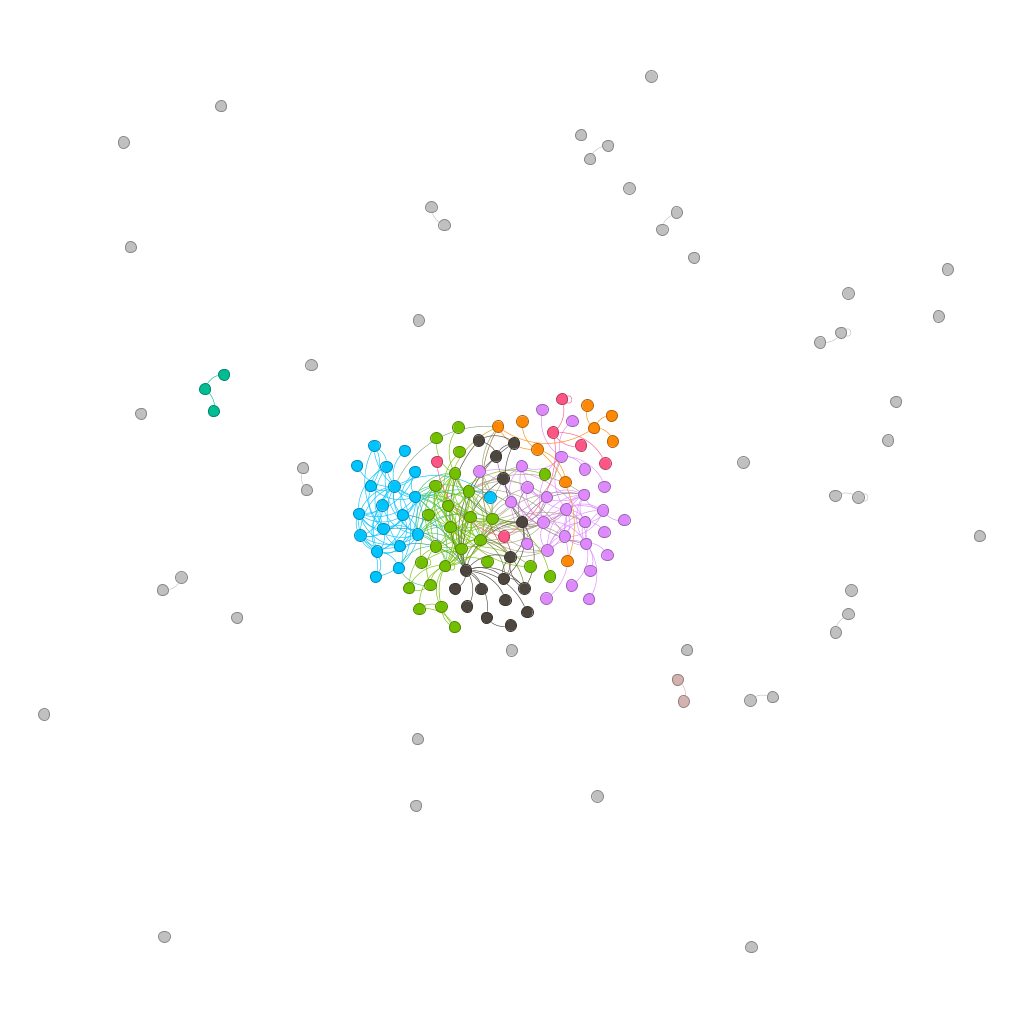

Comunidades Rede Complexa Show da Lady Gaga

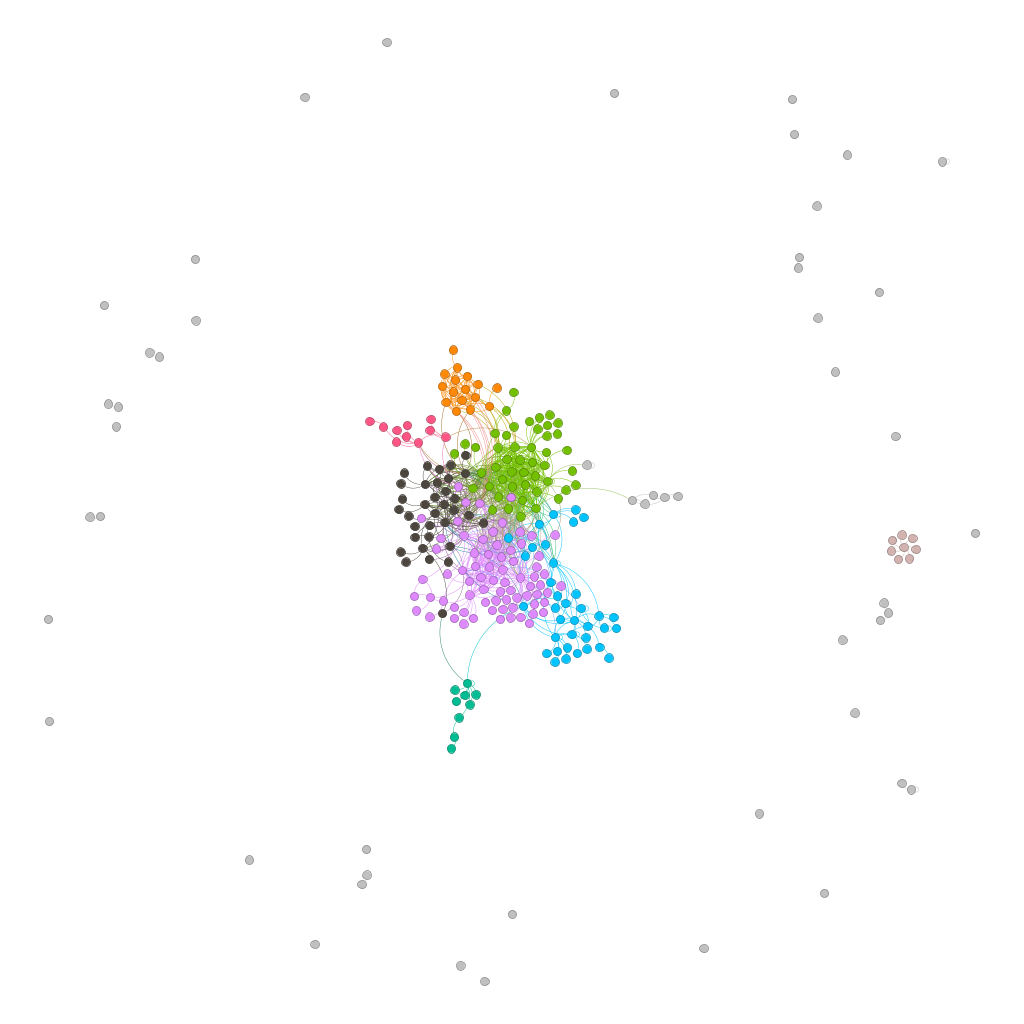